**Part 1 : Miscellaneous**

In [90]:
#Installations

#!pip install emoji
#!pip install nltk
#!pip install transformers
#!pip install torch
#!pip install sentence_transformers
#!pip install textblob
#!pip install keras
#!pip install tensorflow

In [91]:
#Environment details
import platform
import sys

# Python version
python_version = platform.python_version()

# Operating system
os_name = platform.system()
os_version = platform.version()

# Computer details
machine = platform.machine()

# Display information
print(f"Python Version: {python_version}")
print(f"Operating System: {os_name} {os_version}")
print(f"Machine: {machine}")


Python Version: 3.11.5
Operating System: Windows 10.0.22631
Machine: AMD64


In [92]:
#Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import re
import emoji
import random
import string
from nltk.corpus import stopwords
import nltk
import re
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from sentence_transformers import SentenceTransformer
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from textblob import TextBlob
import itertools
from collections import defaultdict
from transformers import AutoTokenizer, AutoModel
from transformers import BertweetTokenizer, RobertaModel
import torch
from transformers import RobertaConfig
import tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import LSTM, Embedding

import warnings
warnings.filterwarnings("ignore")

**Part 2 : Loading Dataset**

In [93]:
#Loading the dataset
path = os.getcwd()
dataset_path = path + '/dataset'
dfs = []
for i,fname in enumerate(os.listdir(dataset_path)):
    if fname.endswith('.xlsx'):
        file_path = os.path.join(dataset_path, fname)
        df = pd.read_excel(file_path)
        dfs.append(df)
df = pd.concat(dfs,ignore_index=True)
df.head()

,question,reply,replies_count,up_counts,relevance_rating
0,What is THE best question to ask on a job inte...,One that has always gone over well for me:\n\n...,7,1047,9.0
1,What is THE best question to ask on a job inte...,"When you were interviewing here, what would yo...",9,2625,6.0
2,What is THE best question to ask on a job inte...,Ask them what is the biggest problem you can s...,9,1669,7.0
3,What is THE best question to ask on a job inte...,A question that landed me a job once was:\n“If...,6,712,8.0
4,What is THE best question to ask on a job inte...,I like to ask:\n\n1. How is success measured i...,6,593,7.0


In [94]:
df.shape

(7938, 5)

In [95]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7938 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7938 non-null   object 
 1   reply             7937 non-null   object 
 2   replies_count     7938 non-null   int64  
 3   up_counts         7938 non-null   int64  
 4   relevance_rating  4832 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 310.2+ KB


**Part 3 : Basic Preprocessing**

In [96]:
df.rename(columns={'reply': 'comment'}, inplace=True)
df.rename(columns={'up_counts': 'score'}, inplace=True)

In [97]:
#Dropping the records with no reply.
df = df.dropna(subset=['comment'])

In [98]:
#Drop duplicate records.
df.drop_duplicates(subset=['question', 'comment'], keep='first', inplace=True)

In [99]:
#Dropping the records which are deleted/removed posts.
invalid_posts = ['[deleted]','[removed]']
df = df[~df['comment'].isin(invalid_posts)]

In [100]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7571 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7571 non-null   object 
 1   comment           7571 non-null   object 
 2   replies_count     7571 non-null   int64  
 3   score             7571 non-null   int64  
 4   relevance_rating  4669 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 354.9+ KB


In [101]:
#Cleaning the comment data.
def clean_text(text):
    #Removing the attached urls
    url_pattern = r'https?://\S+|www\.\S+'
    text = re.sub(url_pattern, '', text)
    #Replacing the \n with spaces
    text = text.replace('\n', ' ')
    #Removing the extra spaces
    text = re.sub(r'\s+', ' ', text)
    text = text.strip()
    #Removing the emojis
    text = emoji.demojize(text)
    return text
df['comment'] = df['comment'].apply(clean_text)

In [102]:
print(df.sample(n=5))

                                               question  \
721   What do y’all think is the Best iphone 15 pro ...   
376   What is THE best question to ask on a job inte...   
6044            What is your favourite game of all time   
6023            What is your favourite game of all time   
53    What is THE best question to ask on a job inte...   

                                                comment  replies_count  score  \
721            Blue Titanium just has that sexy feeling              0      7   
376   talk to them, make them like you and they’ll r...              0      1   
6044  VA11-HALL-A. The music lives rent free in my m...              0      1   
6023                    The Elder Scrolls IV: Oblivion.              0      1   
53    Can you describe the characteristics of people...              0      2   

      relevance_rating  
721                8.0  
376                5.0  
6044               7.0  
6023               6.0  
53                 6.0  


In [103]:
#Checking the target.
df['relevance_rating'].value_counts()

relevance_rating
1.0     992
6.0     840
7.0     595
8.0     587
9.0     417
10.0    357
3.0     225
5.0     214
2.0     212
4.0     156
0.0      74
Name: count, dtype: int64

There are null values and 0 as well when the considered scale is from 1-10.

In [104]:
#replacing the 0s with 1s
df['relevance_rating'] = df['relevance_rating'].replace(0.0, 1.0)
df['relevance_rating'].value_counts()

relevance_rating
1.0     1066
6.0      840
7.0      595
8.0      587
9.0      417
10.0     357
3.0      225
5.0      214
2.0      212
4.0      156
Name: count, dtype: int64

Imbalanced data based on the relevance_ratings.

**Part 4 : Visualizations**

In [105]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7571 entries, 0 to 7937
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   question          7571 non-null   object 
 1   comment           7571 non-null   object 
 2   replies_count     7571 non-null   int64  
 3   score             7571 non-null   int64  
 4   relevance_rating  4669 non-null   float64
dtypes: float64(1), int64(2), object(2)
memory usage: 354.9+ KB


In [106]:
#Shuffling the records.
df = df.sample(frac=1).reset_index(drop=True)

In [107]:
df.describe()

,replies_count,score,relevance_rating
count,7571.000000,7571.000000,4669.000000
mean,0.433100,11.222956,5.372242
std,1.451773,77.151973,3.051719
min,0.000000,-62.000000,1.000000
25%,0.000000,1.000000,2.000000
50%,0.000000,1.000000,6.000000
75%,0.000000,3.000000,8.000000
max,54.000000,2916.000000,10.000000


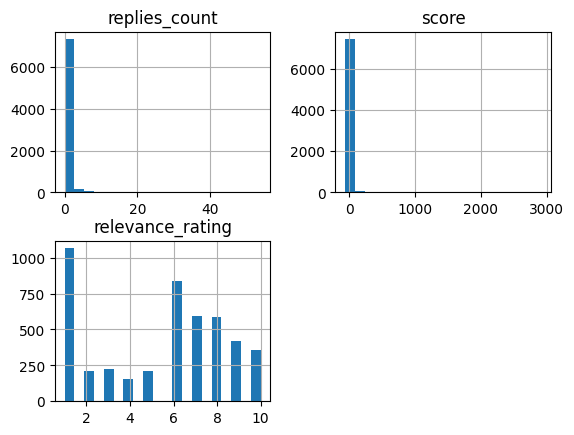

In [108]:
#Continuous values 
df.hist(bins = 20)
plt.show()

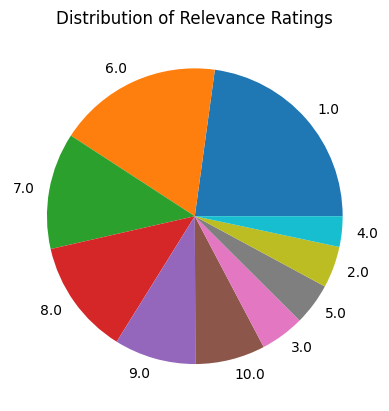

In [109]:
df['relevance_rating'].value_counts().plot.pie()
plt.title('Distribution of Relevance Ratings')
plt.ylabel('')
plt.show()

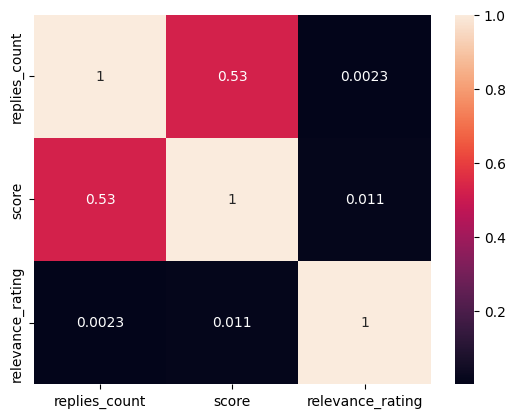

In [110]:
numeric_cols = df.select_dtypes(include=['int64', 'float64'])
sns.heatmap(numeric_cols.corr(), annot=True)
plt.show()

In [111]:
#Just for visualization:
df['question'].value_counts()

question
What is a Pokemon you love that isn't very popular or talked about?        2491
What is your favourite game of all time                                    1251
What do y’all think is the Best iphone 15 pro max color?                    898
Which cities in America is baseball more popular than football?             888
What is THE best question to ask on a job interview?                        671
Most job interviews are harder than the job itself                          344
Anyone else feel like LinkedIn is overrated to job searching?               330
What are your favorite gadgets that make life just a little bit easier?     259
What's YOUR favourite food?                                                 205
Is Youtube music better than Spotify?                                       134
Is baseball poorly designed?                                                100
Name: count, dtype: int64

In [112]:
label_encoder = LabelEncoder()
df_question_encoded = df.copy()
df_question_encoded['question'] = label_encoder.fit_transform(df_question_encoded['question'])

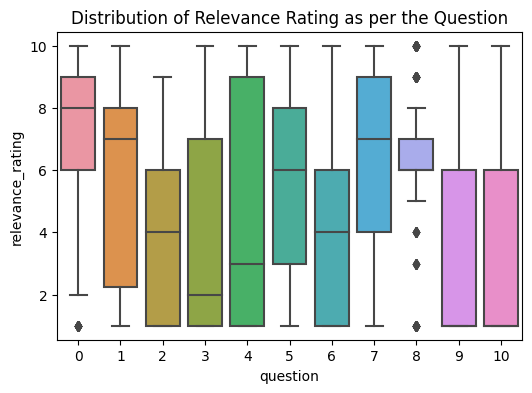

In [113]:
#Distribution of relevance_rating as per the questions.
plt.figure(figsize=(6, 4))
sns.boxplot(data=df_question_encoded, x='question', y='relevance_rating')
plt.title('Distribution of Relevance Rating as per the Question')
plt.show()

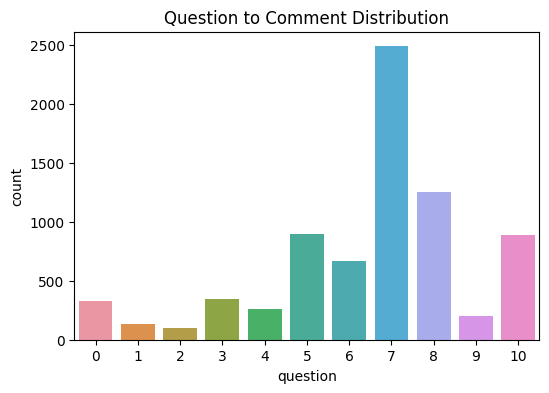

In [114]:
#Distribution of comments as per questions.
plt.figure(figsize=(6, 4))
sns.countplot(data=df_question_encoded, x='question')
plt.title('Question to Comment Distribution')
plt.show()

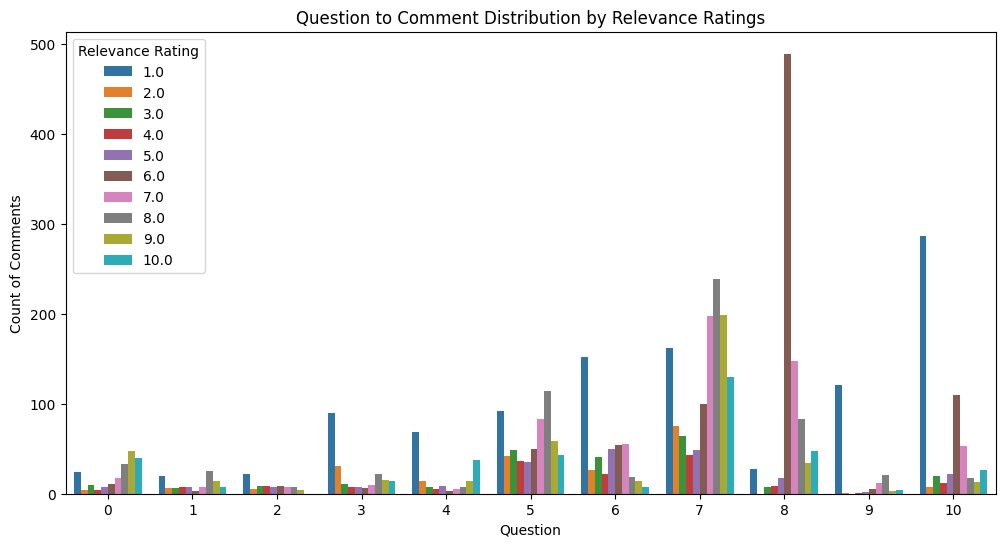

In [115]:
#Question to Comment Distribution divided by Relevance Ratings
plt.figure(figsize=(12, 6))
sns.countplot(data=df_question_encoded, x='question', hue='relevance_rating')
plt.title('Question to Comment Distribution by Relevance Ratings')
plt.xlabel('Question')
plt.ylabel('Count of Comments')
plt.legend(title='Relevance Rating')
plt.show()

**Part 5 : Constructing our metric to calculate relevance as better as possible**

This is all good and fine but in the end how do we find which answers are with good relevance and which are not? <br>
To acheive this, we need to consider various factors like :
1. The semantic similarity of the comment to the question
2. The syntax match of comment to the question
3. The polarity of the comment
4. If we consider clusters, then the coherence factor
5. User engagement factors (like upvotes/downvotes)
6. Temporal relevance (timestamp factor)
7. diversity of perspectives
8. spam/irrelevant content detection in here as well

In [116]:
def calculate_sentiment_probabilities(text):
    analysis = TextBlob(text)
    return analysis.sentiment.polarity
    
def calculate_cosine_similarity_tfidf(question_embedding,cluster_comment_embeddings):
    return cosine_similarity(question_embedding,cluster_comment_embeddings)
    
def calculate_cluster_coherence_tfidf(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    cluster_comment_embeddings_arr = np.array([comment[0] for comment in cluster_comment_embeddings])
    print(cluster_comment_embeddings_arr)
    print(cluster_comment_embeddings_arr.shape)
    if len(cluster_comment_embeddings_arr.shape) > 2:
        cluster_comment_embeddings_arr = cluster_comment_embeddings_arr.reshape(cluster_comment_embeddings_arr.shape[0], -1)
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings_arr)
    coherence = np.mean(pairwise_similarity)
    similarity = calculate_cosine_similarity_tfidf(question_embedding,cluster_comment_embeddings_arr)
    return (coherence,similarity)
    
def calculate_cluster_coherence_lda(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    cluster_comment_embeddings_arr = np.array(cluster_comment_embeddings)
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings_arr)
    coherence = np.mean(pairwise_similarity)
    similarity = calculate_cosine_similarity_tfidf(question_embedding,cluster_comment_embeddings_arr)
    return (coherence,similarity)
    
def calculate_cosine_similarity_pre_trained(question_embedding,cluster_comment_embeddings):
    return cosine_similarity([question_embedding],cluster_comment_embeddings)[0]

def calculate_cluster_coherence_pre_trained(question_embedding,cluster_embeddings,key):
    cluster_comment_embeddings = cluster_embeddings[key]
    pairwise_similarity = cosine_similarity(cluster_comment_embeddings)
    coherence = np.mean(list(itertools.chain.from_iterable(pairwise_similarity)))
    similarity = calculate_cosine_similarity_pre_trained(question_embedding,cluster_comment_embeddings)
    return (coherence,similarity)

def calculate_relevance_scores(df, question_embedding,cluster_embeddings, topics, mode):
    relevance_scores = []
    
    for key,cluster_comments in topics.items():
        # Extracting the comments in this cluster
        df_temp = df[df['comment'].isin(cluster_comments)]
        
        # User engagement factors: score and reply counts
        max_score = max(df_temp['score'])
        min_score = min(df_temp['score'])
        normalized_scores = [(s - min_score) / (max_score - min_score) for s in df_temp['score']]
        
        max_replies = max(df_temp['replies_count'])
        min_replies = min(df_temp['replies_count'])
        normalized_replies = [(count - min_replies) / (max_replies - min_replies) for count in df_temp['replies_count']]
        
        # Cluster coherence,semantic similarity
        coherence,semantic_similarity = eval('calculate_cluster_coherence_' + mode)(question_embedding,cluster_embeddings,key)
        
        # Sentiment polarity of each comment
        sentiments = [calculate_sentiment_probabilities(comment) for comment in cluster_comments]
        max_sentiment = max(sentiments)
        min_sentiment = min(sentiments)
        normalized_sentiment = [(sentiment - min_sentiment) / (max_sentiment - min_sentiment) for sentiment in sentiments]

        # Calculate relevance score for the current cluster
        relevance_score = np.mean(normalized_scores) + (0.25*np.mean(normalized_replies)) + np.mean(normalized_sentiment) + np.mean(semantic_similarity) + coherence        
        relevance_scores.append((str(key),relevance_score))
        
    relevances = [r for _, r in relevance_scores]
    max_relevance = max(relevances)
    min_relevance = min(relevances)
    normalized_relevances = [(relevance - min_relevance) / (max_relevance - min_relevance) for relevance in relevances]
    
    # Create a dictionary with comments as keys and normalized sentiments as values
    relevance_scores = dict(zip(topics.keys(), normalized_relevances))
    return relevance_scores

**Part 6 : Getting into models**

Tried going the supervised way but giving accurate labelling to the posts on our own was kind of stiffling and we tried semi supervised way to give lables to the rest of the data by using label propogation - not very good results. <br>
Check the file : Initial working - Label propogation.ipynb in the same folder. <br>
Hence we are dabbling with unsupervised way now : 

Well ultimately what we need to do is to assign proper weights/embeddings to the words in the sentence so that the similarity metrics later used will provide good outputs. <br>
So the process flow is :
- consider an algorithm/model to assign weights to the sentences i.e, the approach is to create a complex model where the input is a string, and the output is a representation of the word or sentence (called embedding) and these embeddings should accurately represent the syntax and semantic.
- then use a similarity/distance metric among the embeddings to give a number!
- We can also use correlation coefficients i guess (lets check)

Some context for this : there are multiple ways to provide an embedding:<br>
1. Using simple similarity metrics like - cosine similiarity, Word Mover's Distance, Levenshtein distance, Hamming distance etc.
2. Using Word Embeddings (Spacy,bag-of-words,tf-idf,smooth inverse frequency)
3. Word2Vec or Doc2Vec
4. Pre-trained encoders (Transfer learning)
5. Bert embeddings
6. OpenAI
7. Siamese Networks? - needs labelling itseems
8. Semantic matching techniques ?
9. Transformers using attention mechanism

But the above points are all good for finding the syntax and similarity. How about contextual relevance then? <br>
Possible options for us to try would be : 
- Pre-trained models like bert and gpt
- Siamese networks
- Semantic matching models

I am going to use all of these and also in combinations (hybrid models).

 - <strong>Tf-Idf with Nearest neighbors</strong>

In [117]:
nltk.download('stopwords')
stop = stopwords.words('english')

def remove_special_characters(text):
    pattern = r'[^a-zA-Z0-9\s]'
    clean_text = re.sub(pattern, '', text)    
    return clean_text
    
#Not using this for now!
def remove_stopwords(text):
    words = text.split()
    return ' '.join([word for word in words if word.lower() not in stop])

df['comment'] = df['comment'].apply(remove_special_characters).str.lower()
df['question'] = df['question'].apply(remove_special_characters).str.lower()
df.head()

[nltk_data] Downloading package stopwords to C:\Users\Vineetha
[nltk_data]     Maddikunta\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


,question,comment,replies_count,score,relevance_rating
0,what is your favourite game of all time,crazy that my two favorite games both released...,0,4,NaN
1,anyone else feel like linkedin is overrated to...,the feed on linkedin is where users go to show...,0,6,NaN
2,what is a pokemon you love that isnt very popu...,heliolisk his design is top tier,0,1,NaN
3,what is the best question to ask on a job inte...,if you had unlimited funds and time what is so...,0,1,4.0
4,what is the best question to ask on a job inte...,the got tired of the constant blowjobs,1,84,NaN


Lets check the basic similarities between the question and replies and among replies as well.

In [118]:
question1df = df[df['question'] == df['question'][0]]

question = question1df['question'][0]
comments = question1df['comment'].to_numpy(dtype='object')

In [119]:
vectorizer = TfidfVectorizer()
comment_vectors = vectorizer.fit_transform(question1df['comment'])
question_vectors = vectorizer.transform(question1df['question'])

# Compute pairwise cosine similarity between sentence vectors
cosine_similarities = cosine_similarity(comment_vectors)
cosine_similarities_qv = cosine_similarity(comment_vectors, question_vectors)

# Print cosine similarity matrix
print("Cosine Similarity Matrix:")
print(pd.DataFrame(cosine_similarities))

Cosine Similarity Matrix:
          0         1         2         3         4         5         6     \
0     1.000000  0.020322  0.045843  0.031001  0.043416  0.029595  0.030805   
1     0.020322  1.000000  0.024555  0.036167  0.014024  0.034527  0.035938   
2     0.045843  0.024555  1.000000  0.037460  0.014525  0.035761  0.037223   
3     0.031001  0.036167  0.037460  1.000000  0.047222  0.765960  0.054824   
4     0.043416  0.014024  0.014525  0.047222  1.000000  0.045080  0.040451   
...        ...       ...       ...       ...       ...       ...       ...   
1246  0.000000  0.047118  0.055622  0.000000  0.000000  0.000000  0.000000   
1247  0.000000  0.000000  0.000000  0.000000  0.050064  0.000000  0.000000   
1248  0.044171  0.051531  0.053373  0.078611  0.065397  0.075046  0.078114   
1249  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
1250  0.019578  0.023026  0.050838  0.000000  0.012007  0.000000  0.000000   

      7         8         9     ...  

In [120]:
def get_top_similar_pairs(cosine_similarity_matrix):
    num_records = cosine_similarity_matrix.shape[0]
    pairs = []

    # Iterate through upper triangle of similarity matrix
    for i in range(num_records):
        for j in range(i+1, num_records):
            pairs.append(((i, j), cosine_similarity_matrix[i, j]))

    # Sort pairs by similarity score in descending order
    pairs.sort(key=lambda x: x[1], reverse=True)
    return pairs

top_n = 5
top_similar_pairs = get_top_similar_pairs(cosine_similarities)
top_pairs = top_similar_pairs[:top_n]
print("Top", top_n, "similar pairs:")
for pair, similarity_score in top_pairs:
    print("Pair:", pair, "Similarity Score:", similarity_score)
    print(question1df.iloc[pair[0]]['comment'], "\nand\n" , question1df.iloc[pair[1]]['comment'])
    print("--------------------------------------")

Top 5 similar pairs:
Pair: (35, 856) Similarity Score: 1.0000000000000002
chrono trigger 
and
 chrono trigger
--------------------------------------
Pair: (52, 1171) Similarity Score: 1.0000000000000002
super mario world 
and
 super mario world
--------------------------------------
Pair: (57, 585) Similarity Score: 1.0000000000000002
sekiro shadows die twice 
and
 sekiro shadows die twice
--------------------------------------
Pair: (57, 925) Similarity Score: 1.0000000000000002
sekiro shadows die twice 
and
 sekiro shadows die twice
--------------------------------------
Pair: (57, 1234) Similarity Score: 1.0000000000000002
sekiro shadows die twice 
and
 sekiro shadows die twice
--------------------------------------


In [121]:
top_similar_pairs = get_top_similar_pairs(cosine_similarities_qv)
top_pairs = top_similar_pairs[:top_n]
print("Top", top_n, "similar pairs:")
for pair, similarity_score in top_pairs:
    print("Pair:", pair, "Similarity Score:", similarity_score)
    print(question1df.iloc[pair[0]]['comment'], "\nand\n" , question1df.iloc[pair[1]]['comment'])
    print("--------------------------------------")

Top 5 similar pairs:
Pair: (619, 620) Similarity Score: 0.45618931301282073
red dead 2 your favourite isnt it 
and
 8 year old me agrees 30 year old me does as well
--------------------------------------
Pair: (619, 621) Similarity Score: 0.45618931301282073
red dead 2 your favourite isnt it 
and
 grand theft auto iv
--------------------------------------
Pair: (619, 622) Similarity Score: 0.45618931301282073
red dead 2 your favourite isnt it 
and
 undertale followed closely by wind waker
--------------------------------------
Pair: (619, 623) Similarity Score: 0.45618931301282073
red dead 2 your favourite isnt it 
and
 ocarina of time is legendary but majoras mask beats it for me personally it blows my mind how it was made in around a year
--------------------------------------
Pair: (619, 624) Similarity Score: 0.45618931301282073
red dead 2 your favourite isnt it 
and
 can you explain the appeal i tried p3r yesterday and it felt like playing dnd when the dm railroads you or a movie 

In [122]:
nn_model = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
nn_model.fit(comment_vectors.toarray())

# Query the model to find the most similar sentence to the first sentence
query_vec = vectorizer.transform([' '.join(df['question'][0])])
distances, indices = nn_model.kneighbors(query_vec.toarray(), return_distance=True)

# Print the most similar sentence
print(indices)
print("Most similar sentence to '{}'".format(df['question'][0]))
for i in indices[0]:
    print(question1df.iloc[i]['comment'])
    print("\n")

[[835 837 834 832 836 838]]
Most similar sentence to 'what is your favourite game of all time'
assassins creed black flag


rain world its just the best thing ever


god of war 2018


i mean hard as hell to beat mass effect 2


astroneer


its definitely an amazing game pillars 1 though is only like a top 30 game for me while 2 is tied for top 1 between the other two so the games differ quite a bit poe 2 improves upon every aspect from the first imo the first being the highest grossing kickstarter campaign at the time its really just a massive open world game similar to morrowind and new vegas in that you can kill every npc if you wanted with a faction and reputation system of new vegas




In [123]:
num_topics = 5  
kmeans_tfidf = KMeans(n_clusters=num_topics)
kmeans_tfidf.fit(comment_vectors)

# Assign each comment to a cluster
cluster_labels_tfidf = kmeans_tfidf.labels_

cluster_embeddings_tfidf = defaultdict(list)
for i, label in enumerate(cluster_labels_tfidf):
    cluster_embeddings_tfidf[label].append(comment_vectors[i])
cluster_embeddings_tfidf = dict(cluster_embeddings_tfidf)

# Print comments belonging to each cluster (topic)
topics_tfidf = {}
for i, comment in enumerate(comments):
    if cluster_labels_tfidf[i] not in topics_tfidf:
        topics_tfidf[cluster_labels_tfidf[i]] = []
    topics_tfidf[cluster_labels_tfidf[i]].append(comment)

In [124]:
filtered_data = {key: value[:4] for key, value in topics_tfidf.items()}
pd.DataFrame(filtered_data)

,3,2,1,0,4
0,crazy that my two favorite games both released...,terraria its a game i find myself coming back ...,red dead redemption 2 or halo 3,secret of monkey island,halo 2 multiplayer
1,ok thats what i assumed but didnt want to miss...,good question my buddy keeps telling me to go ...,dead space 2008 2023,shadow of the colossus all time fav dishonoure...,reach represent i grew up with halo 2 but reac...
2,chrono trigger ops suggestion hurts me down to...,oblivion havent played elden ring though and v...,red dead redemption 2 easily that ending broke me,i absolutely love breathe of the wild but i th...,most underrated halo game by far the best endi...
3,i had to scroll too far for this,orcarina of time no other game will give me th...,red dead or god of war fire,the last of us or maybe ocarina of time or pos...,halo 123 hands down i have so many grabbed by ...


In [125]:
# relevance_scores_tfidf = calculate_relevance_scores(question1df,question_vectors,cluster_embeddings_tfidf,topics_tfidf,'tfidf')
# print("Relevance Scores for Each Cluster:", relevance_scores_tfidf)

- **Latent Dirichlet Allocation (LDA) for topic modeling**

In [126]:
# Vectorize the corpus using TF-IDF
vectorizer2 = TfidfVectorizer()
X = vectorizer2.fit_transform([question] + comments)

# Apply Latent Dirichlet Allocation (LDA) for topic modeling
lda_model = LatentDirichletAllocation(n_components=2, random_state=42)
lda_model.fit(X)

# Transform question and comments to topic distributions
question_topic = lda_model.transform(vectorizer2.transform([question]))
comment_topics = lda_model.transform(vectorizer2.transform(comments))

# Calculate cosine similarity between question topic and comment topics
similarity_scores = cosine_similarity(question_topic, comment_topics)[0]

# Filter relevant comments based on semantic similarity
threshold = np.percentile(similarity_scores, 50)  # Adjust threshold as needed
relevant_comments = [(comment,score) for comment, score in zip(comments, similarity_scores)]
relevant_comments = sorted(relevant_comments, key=lambda x: x[1], reverse=True)
print("Question : ",question)
print("Relevant comments:")
for comment,score in relevant_comments:
    print("-", comment,score)

Question :  what is your favourite game of all time
Relevant comments:
- nothing 0.9999999950593159
- based 0.999999946836084
- pretty much any pokmon game or and fnaf game 0.9999999381769218
- zelda 3 0.9999955540280856
- zelda 0.9999955540280856
- right 0.9999953099367054
- minecraft 0.9999939883697088
- minecraft 0.9999939883697088
- minecraft 0.9999939883697088
- persona 3 0.9999872221265476
- persona 5 0.9999872221265476
- yes 0.9999838568007986
- farming simulator 22 0.9999830604126205
- off 0.9999829833039585
- same 0.999982501430277
- same 0.999982501430277
- halo 3 0.9999791663232818
- halo 2 0.9999791663232818
- halo 3 0.9999791663232818
- oot 0.9999712708467142
- hell yeah 0.999966041436036
- controversial opinion but i like fortnite 0.9999656777444782
- botw 0.9999648264479852
- v rising 0.9999464404254333
- mine is super mario galaxy 0.999945761893768
- i think i have like 900 hours on botw my poor preordered 2017 running totkskull 0.9999334045334451
- ocarina of time a li

Observations : 
1. Pretty accurate for correct ones but also classified a lot of correct ones as wrong ones.
2. Works good for small sentences but seems to be failing for longer sentences with more explanation.

In [127]:
num_topics = 5  
kmeans_lda = KMeans(n_clusters=num_topics)
kmeans_lda.fit(comment_topics)

# Assign each comment to a cluster
cluster_labels_lda = kmeans_lda.labels_

cluster_embeddings_lda = defaultdict(list)
for i, label in enumerate(cluster_labels_lda):
    cluster_embeddings_lda[label].append(comment_topics[i])
cluster_embeddings_lda = dict(cluster_embeddings_lda)

# Print comments belonging to each cluster (topic)
topics_lda = {}
for i, comment in enumerate(comments):
    if cluster_labels_lda[i] not in topics_lda:
        topics_lda[cluster_labels_lda[i]] = []
    topics_lda[cluster_labels_lda[i]].append(comment)

In [128]:
filtered_data = {key: value[:3] for key, value in topics_lda.items()}
pd.DataFrame(filtered_data)

,2,4,3,0,1
0,crazy that my two favorite games both released...,ok thats what i assumed but didnt want to miss...,chrono trigger ops suggestion hurts me down to...,same,red dead redemption 2 or halo 3
1,i had to scroll too far for this,bring it to pc fromsoft,ff9,holy hell,secret of monkey island
2,terraria its a game i find myself coming back ...,tears is better than botw,elder scrolls iv oblivion objectively skyrim i...,v rising,metro exodus


In [129]:
relevance_scores_lda = calculate_relevance_scores(question1df,question_topic,cluster_embeddings_lda,topics_lda,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_lda)

Relevance Scores for Each Cluster: {2: 0.9210671420477694, 4: 1.0, 3: 0.4734976716444163, 0: 0.9209739717253058, 1: 0.0}


- **Pre-trained models** (Transfer Learning)

In [130]:
model = SentenceTransformer('paraphrase-distilroberta-base-v2')
comment_embeddings = model.encode(comments)
question_embedding = model.encode(question)
num_topics = 5  
kmeans = KMeans(n_clusters=num_topics)
kmeans.fit(comment_embeddings)

# Assign each comment to a cluster
cluster_labels = kmeans.labels_

cluster_embeddings = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings):
    cluster_label = cluster_labels[i]
    cluster_embeddings[cluster_label].append(comment_embedding)
cluster_embeddings = dict(cluster_embeddings)
# Print comments belonging to each cluster (topic)
topics = {}
for i, comment in enumerate(comments):
    if cluster_labels[i] not in topics:
        topics[cluster_labels[i]] = []
    topics[cluster_labels[i]].append(comment)

In [131]:
filtered_data = {key: value[:4] for key, value in topics.items()}
pd.DataFrame(filtered_data)

,4,0,2,1,3
0,crazy that my two favorite games both released...,ok thats what i assumed but didnt want to miss...,chrono trigger ops suggestion hurts me down to...,acnh or totk or hogwarts legacy theyre so diff...,resident evil 1 remake no its actually castlev...
1,terraria its a game i find myself coming back ...,yes raisinghandslightskintone mine is exactly ...,i had to scroll too far for this,red dead redemption 2 or halo 3,monster hunter
2,good question my buddy keeps telling me to go ...,same,had to scroll way too much for this,varies but skyrim will always be top 5 atm my ...,somewhere in between twilight princess stray a...
3,oblivion havent played elden ring though and v...,holy hell,bring it to pc fromsoft,id say kingdom hearts 25 or 3 remind,shadow of the colossus all time fav dishonoure...


In [132]:
relevance_scores = calculate_relevance_scores(question1df,question_embedding,cluster_embeddings,topics,'pre_trained')
print("Relevance Scores for Each Cluster:", relevance_scores)

Relevance Scores for Each Cluster: {4: 1.0, 0: 0.27587942594410997, 2: 0.0, 1: 0.34574687781818486, 3: 0.2808129401385601}


- **Pre-trained models (Another version of Bert)**

In [133]:
comments.shape

(1251,)

In [134]:
model2 = SentenceTransformer('vinai/bertweet-base', device='cpu') 
comment_embeddings_m2 = []
for comment in comments:
    if len(comment) > model2.max_seq_length:
       comment = comment[:model2.max_seq_length]
    comment_embedding = model2.encode(comment)
    comment_embeddings_m2.append(torch.from_numpy(comment_embedding))
comment_embeddings_m2 = torch.stack(comment_embeddings_m2)
question_embedding_m2 = model2.encode(question)

num_topics = 5  
kmeans2 = KMeans(n_clusters=num_topics)
kmeans2.fit(comment_embeddings_m2)
cluster_labels_m2 = kmeans2.labels_

cluster_embeddings_m2 = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings_m2):
    cluster_label = cluster_labels_m2[i]
    cluster_embeddings_m2[cluster_label].append(comment_embedding)
cluster_embeddings_m2 = dict(cluster_embeddings_m2)

topics2 = {}
for i, comment in enumerate(comments):
    if cluster_labels_m2[i] not in topics2:
        topics2[cluster_labels_m2[i]] = []
    topics2[cluster_labels_m2[i]].append(comment)

No sentence-transformers model found with name vinai/bertweet-base. Creating a new one with MEAN pooling.


In [135]:
filtered_data = {key: value[:4] for key, value in topics2.items()}
pd.DataFrame(filtered_data)

,3,1,4,2,0
0,crazy that my two favorite games both released...,ok thats what i assumed but didnt want to miss...,bring it to pc fromsoft,ff9,red dead redemption 2 or halo 3
1,terraria its a game i find myself coming back ...,chrono trigger ops suggestion hurts me down to...,tears is better than botw,same,monster hunter
2,yes raisinghandslightskintone mine is exactly ...,i had to scroll too far for this,secret of monkey island,holy hell,id say kingdom hearts 25
3,good question my buddy keeps telling me to go ...,had to scroll way too much for this,was this the porn parody,v rising,super mario world


In [136]:
relevance_scores_m2 = calculate_relevance_scores(question1df,question_embedding_m2,cluster_embeddings_m2,topics2,'pre_trained')
print("Relevance Scores for Each Cluster:", relevance_scores_m2)

Relevance Scores for Each Cluster: {3: 1.0, 1: 0.5223413323552585, 4: 0.6907792424970092, 2: 0.13722914377441925, 0: 0.0}


- **LSTM model**

In [137]:
tokenizer_lstm = Tokenizer()
tokenizer_lstm.fit_on_texts(comments)
sequences = tokenizer_lstm.texts_to_sequences(comments)
vocab_size = len(tokenizer_lstm.word_index) + 1 
max_sequence_length = max(len(seq) for seq in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length)

# Model hyperparameters
embedding_dim = 50 
# Define the model
model_lstm = Sequential()
model_lstm.add(Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_sequence_length))
model_lstm.add(LSTM(units=64))

# Compile the model (not necessary if you're not training)
model_lstm.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Get embeddings
comment_embeddings_lstm = model_lstm.predict(padded_sequences)

40/40 ━━━━━━━━━━━━━━━━━━━━ 5s 102ms/step


In [138]:
tokenizer_lstm.fit_on_texts([question])
sequence = tokenizer_lstm.texts_to_sequences([question])
vocab_size = len(tokenizer_lstm.word_index) + 1
max_sequence_length = len(sequence[0])
padded_sequence = pad_sequences(sequence, maxlen=max_sequence_length)
question_embeddings_lstm = model_lstm.predict(padded_sequence)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step


In [139]:
num_topics = 5  
kmeans_lstm = KMeans(n_clusters=num_topics)
kmeans_lstm.fit(comment_embeddings_lstm)

# Assign each comment to a cluster
cluster_labels_lstm = kmeans_lstm.labels_

cluster_embeddings_lstm = defaultdict(list)
for i, comment_embedding in enumerate(comment_embeddings_lstm):
    cluster_label = cluster_labels_lstm[i]
    cluster_embeddings_lstm[cluster_label].append(comment_embedding)
cluster_embeddings_lstm = dict(cluster_embeddings_lstm)

# Print comments belonging to each cluster (topic)
topics_lstm = {}
for i, comment in enumerate(comments):
    if cluster_labels_lstm[i] not in topics_lstm:
        topics_lstm[cluster_labels_lstm[i]] = []
    topics_lstm[cluster_labels_lstm[i]].append(comment)

In [140]:
filtered_data = {key: value[:4] for key, value in topics2.items()}
pd.DataFrame(filtered_data)

,3,1,4,2,0
0,crazy that my two favorite games both released...,ok thats what i assumed but didnt want to miss...,bring it to pc fromsoft,ff9,red dead redemption 2 or halo 3
1,terraria its a game i find myself coming back ...,chrono trigger ops suggestion hurts me down to...,tears is better than botw,same,monster hunter
2,yes raisinghandslightskintone mine is exactly ...,i had to scroll too far for this,secret of monkey island,holy hell,id say kingdom hearts 25
3,good question my buddy keeps telling me to go ...,had to scroll way too much for this,was this the porn parody,v rising,super mario world


In [141]:
relevance_scores_lstm = calculate_relevance_scores(question1df,question_embeddings_lstm,cluster_embeddings_lstm,topics_lstm,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_lstm)

Relevance Scores for Each Cluster: {3: 0.0, 0: 0.14085007529617052, 2: 0.8525137761963076, 4: 0.3806583781422411, 1: 1.0}


- **Hybrid model - LDA + Bert**

In [142]:
question_embedding.shape

(768,)

In [143]:
combined_embeddings1 = np.concatenate((comment_topics, comment_embeddings), axis=1)
question_embedding_reshaped = question_embedding.reshape(1, -1)
question_combined1 = np.concatenate((question_topic, question_embedding_reshaped), axis=1)
num_topics = 5
kmeans_hybrid1 = KMeans(n_clusters=num_topics)
kmeans_hybrid1.fit(combined_embeddings1)

# Assign each comment to a cluster
cluster_labels_hybrid1 = kmeans_hybrid1.labels_

cluster_embeddings_h1 = defaultdict(list)
for i, comment_embedding in enumerate(combined_embeddings1):
    cluster_label = cluster_labels_hybrid1[i]
    cluster_embeddings_h1[cluster_label].append(comment_embedding)
cluster_embeddings_h1 = dict(cluster_embeddings_h1)

# Print comments belonging to each cluster (topic)
topics_hybrid1 = {}
for i, comment in enumerate(comments):
    if cluster_labels_hybrid1[i] not in topics_hybrid1:
        topics_hybrid1[cluster_labels_hybrid1[i]] = []
    topics_hybrid1[cluster_labels_hybrid1[i]].append(comment)

In [144]:
filtered_data = {key: value[:4] for key, value in topics_hybrid1.items()}
pd.DataFrame(filtered_data)

,2,4,0,3,1
0,crazy that my two favorite games both released...,ok thats what i assumed but didnt want to miss...,chrono trigger ops suggestion hurts me down to...,i had to scroll too far for this,acnh or totk or hogwarts legacy theyre so diff...
1,terraria its a game i find myself coming back ...,yes raisinghandslightskintone mine is exactly ...,bring it to pc fromsoft,had to scroll way too much for this,resident evil 1 remake no its actually castlev...
2,good question my buddy keeps telling me to go ...,same,ff9,holy hell,red dead redemption 2 or halo 3
3,oblivion havent played elden ring though and v...,tears is better than botw,v rising,secret of monkey island,varies but skyrim will always be top 5 atm my ...


In [145]:
relevance_scores_h1 = calculate_relevance_scores(question1df,question_combined1,cluster_embeddings_h1,topics_hybrid1,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_h1)

Relevance Scores for Each Cluster: {2: 1.0, 4: 0.4443520845665359, 0: 0.0, 3: 0.1532618451203456, 1: 0.3530801650036918}


- **Hybrid model - LDA + LSTM**

In [146]:
combined_embeddings2 = np.concatenate((comment_topics, comment_embeddings_lstm), axis=1)
question_embedding_reshaped = question_embeddings_lstm.reshape(1, -1)
question_combined2 = np.concatenate((question_topic, question_embedding_reshaped), axis=1)
num_topics = 5
kmeans_hybrid2 = KMeans(n_clusters=num_topics)
kmeans_hybrid2.fit(combined_embeddings2)

# Assign each comment to a cluster
cluster_labels_hybrid2 = kmeans_hybrid2.labels_

cluster_embeddings_h2 = defaultdict(list)
for i, comment_embedding in enumerate(combined_embeddings2):
    cluster_label = cluster_labels_hybrid2[i]
    cluster_embeddings_h2[cluster_label].append(comment_embedding)
cluster_embeddings_h2 = dict(cluster_embeddings_h2)

# Print comments belonging to each cluster (topic)
topics_hybrid2 = {}
for i, comment in enumerate(comments):
    if cluster_labels_hybrid2[i] not in topics_hybrid2:
        topics_hybrid2[cluster_labels_hybrid2[i]] = []
    topics_hybrid2[cluster_labels_hybrid2[i]].append(comment)

In [147]:
filtered_data = {key: value[:4] for key, value in topics_hybrid2.items()}
pd.DataFrame(filtered_data)

,2,4,3,0,1
0,crazy that my two favorite games both released...,ok thats what i assumed but didnt want to miss...,chrono trigger ops suggestion hurts me down to...,same,red dead redemption 2 or halo 3
1,i had to scroll too far for this,bring it to pc fromsoft,ff9,holy hell,secret of monkey island
2,terraria its a game i find myself coming back ...,tears is better than botw,elder scrolls iv oblivion objectively skyrim i...,v rising,metro exodus
3,had to scroll way too much for this,oblivion havent played elden ring though and v...,monster hunter,id say kingdom hearts 25 or 3 remind,somewhere in between twilight princess stray a...


In [148]:
relevance_scores_h2 = calculate_relevance_scores(question1df,question_combined2,cluster_embeddings_h2,topics_hybrid2,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_h2)

Relevance Scores for Each Cluster: {2: 0.657086655245697, 4: 1.0, 3: 0.4013118357017251, 0: 0.7913859144832419, 1: 0.0}


- **Hybrid model - LDA + Bertweet**

In [149]:
combined_embeddings3 = np.concatenate((comment_topics, comment_embeddings_m2), axis=1)
question_embedding_reshaped = question_embedding_m2.reshape(1, -1)
question_combined3 = np.concatenate((question_topic, question_embedding_reshaped), axis=1)
num_topics = 5
kmeans_hybrid3 = KMeans(n_clusters=num_topics)
kmeans_hybrid3.fit(combined_embeddings3)

# Assign each comment to a cluster
cluster_labels_hybrid3 = kmeans_hybrid3.labels_

cluster_embeddings_h3 = defaultdict(list)
for i, comment_embedding in enumerate(combined_embeddings3):
    cluster_label = cluster_labels_hybrid3[i]
    cluster_embeddings_h3[cluster_label].append(comment_embedding)
cluster_embeddings_h3 = dict(cluster_embeddings_h3)

# Print comments belonging to each cluster (topic)
topics_hybrid3 = {}
for i, comment in enumerate(comments):
    if cluster_labels_hybrid3[i] not in topics_hybrid3:
        topics_hybrid3[cluster_labels_hybrid3[i]] = []
    topics_hybrid3[cluster_labels_hybrid3[i]].append(comment)

In [150]:
filtered_data = {key: value[:4] for key, value in topics_hybrid3.items()}
pd.DataFrame(filtered_data)

,4,2,3,1,0
0,crazy that my two favorite games both released...,ok thats what i assumed but didnt want to miss...,bring it to pc fromsoft,ff9,red dead redemption 2 or halo 3
1,terraria its a game i find myself coming back ...,chrono trigger ops suggestion hurts me down to...,tears is better than botw,same,id say kingdom hearts 25
2,yes raisinghandslightskintone mine is exactly ...,i had to scroll too far for this,secret of monkey island,holy hell,super mario world
3,good question my buddy keeps telling me to go ...,had to scroll way too much for this,was this the porn parody,v rising,metal gear solid 3


In [151]:
relevance_scores_h3 = calculate_relevance_scores(question1df,question_combined3,cluster_embeddings_h3,topics_hybrid3,'lda')
print("Relevance Scores for Each Cluster:", relevance_scores_h3)

Relevance Scores for Each Cluster: {4: 1.0, 2: 0.8535676725320493, 3: 0.980007583087583, 1: 0.0, 0: 0.4657945158201296}
